# Plant Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14440 files belonging to 15 classes.


In [4]:
class_names = train_dataset.class_names
N_CLASSES = len(class_names)
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 7 10  8 12 12 12  5  9  2  9 12  1 12 14  8  2  8  2  7  5 12 12  9 12
  0 10  1 12  8  7  6  7]


In [6]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2058 files belonging to 15 classes.


In [7]:
for image_batch, labels_batch in validation_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 1 14 10 12  0  7  8  2 13  9 12  7 10  4  0  9 10  1 10  0 12  7  7 14
 14 12  7 14  6  3 11  5]


In [8]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4140 files belonging to 15 classes.


In [9]:
for image_batch, labels_batch in test_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[12  5  2  5  0  6  8  5  5  8  5 10  5 10 12  1 12  9 14 12 10 12  9 10
  5 12  6 13  5  2  2 10]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

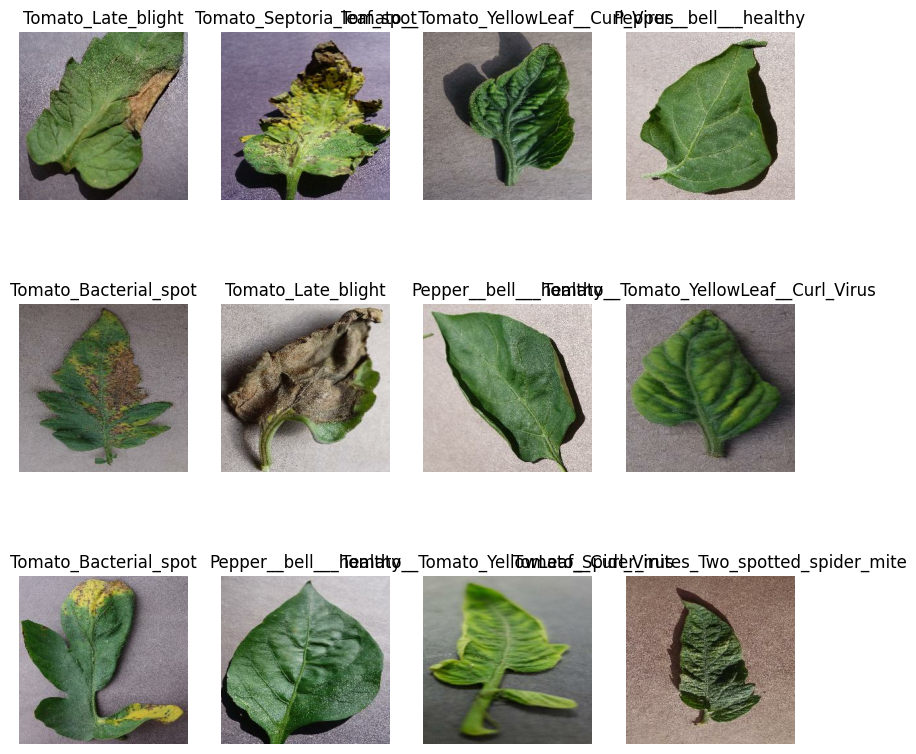

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

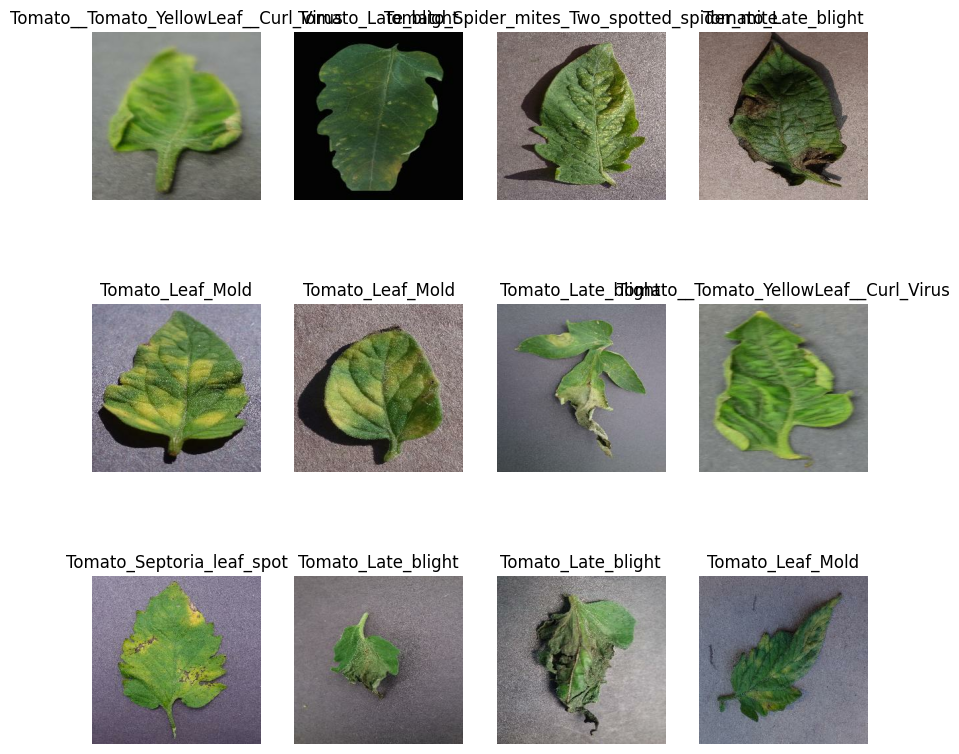

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in validation_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

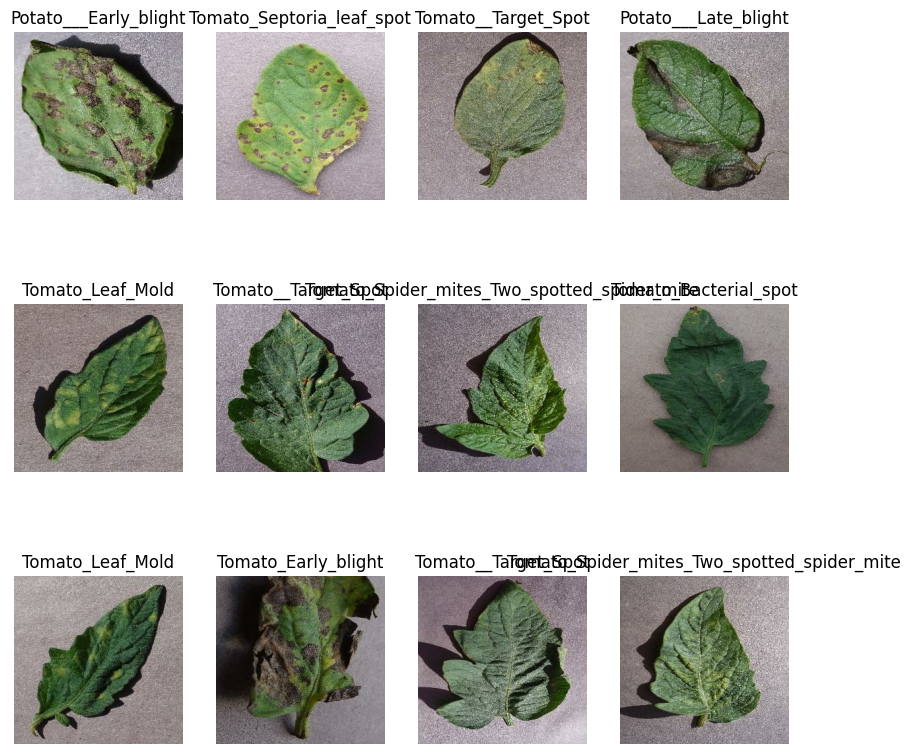

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Cache, Shuffle, and Prefetch the Dataset

In [13]:
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Create Checkpoints

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = "../checkpoints/plant-disease-model-with-split-folders/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/30
452/452 [==============================] - ETA: 0s - loss: 2.1668 - accuracy: 0.2854
Epoch 1: val_accuracy improved from -inf to 0.40087, saving model to ../checkpoints/plant-disease-model-with-split-folders\model-01-0.4009.hdf5
452/452 [==============================] - 336s 680ms/step - loss: 2.1668 - accuracy: 0.2854 - val_loss: 1.8769 - val_accuracy: 0.4009
Epoch 2/30
452/452 [==============================] - ETA: 0s - loss: 1.4288 - accuracy: 0.5242
Epoch 2: val_accuracy improved from 0.40087 to 0.55782, saving model to ../checkpoints/plant-disease-model-with-split-folders\model-02-0.5578.hdf5
452/452 [==============================] - 285s 631ms/step - loss: 1.4288 - accuracy: 0.5242 - val_loss: 1.3831 - val_accuracy: 0.5578
Epoch 3/30
452/452 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.6687
Epoch 3: val_accuracy improved from 0.55782 to 0.64529, saving model to ../checkpoints/plant-disease-model-with-split-folders\model-03-0.6453.hdf5
452/

In [22]:
scores = model.evaluate(test_ds)

130/130 [==============================] - 30s 156ms/step - loss: 0.3806 - accuracy: 0.8942


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [23]:
scores

[0.3806016147136688, 0.8942028880119324]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [24]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [25]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 452}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

30

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.166774034500122,
 1.428823709487915,
 0.9603919982910156,
 0.7503583431243896,
 0.6245696544647217]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

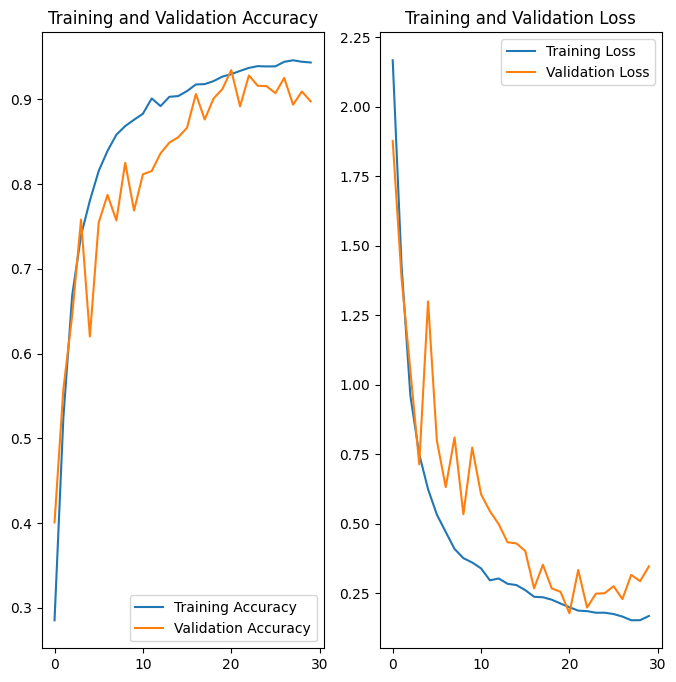

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 3s 3s/step
predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


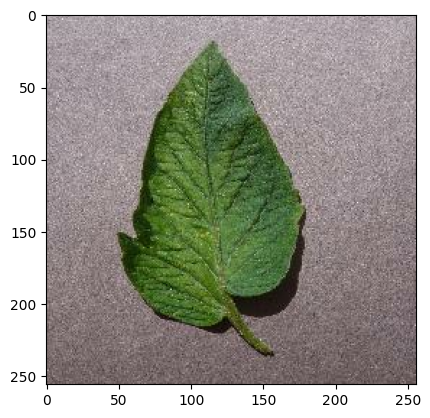

In [32]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 21ms/step


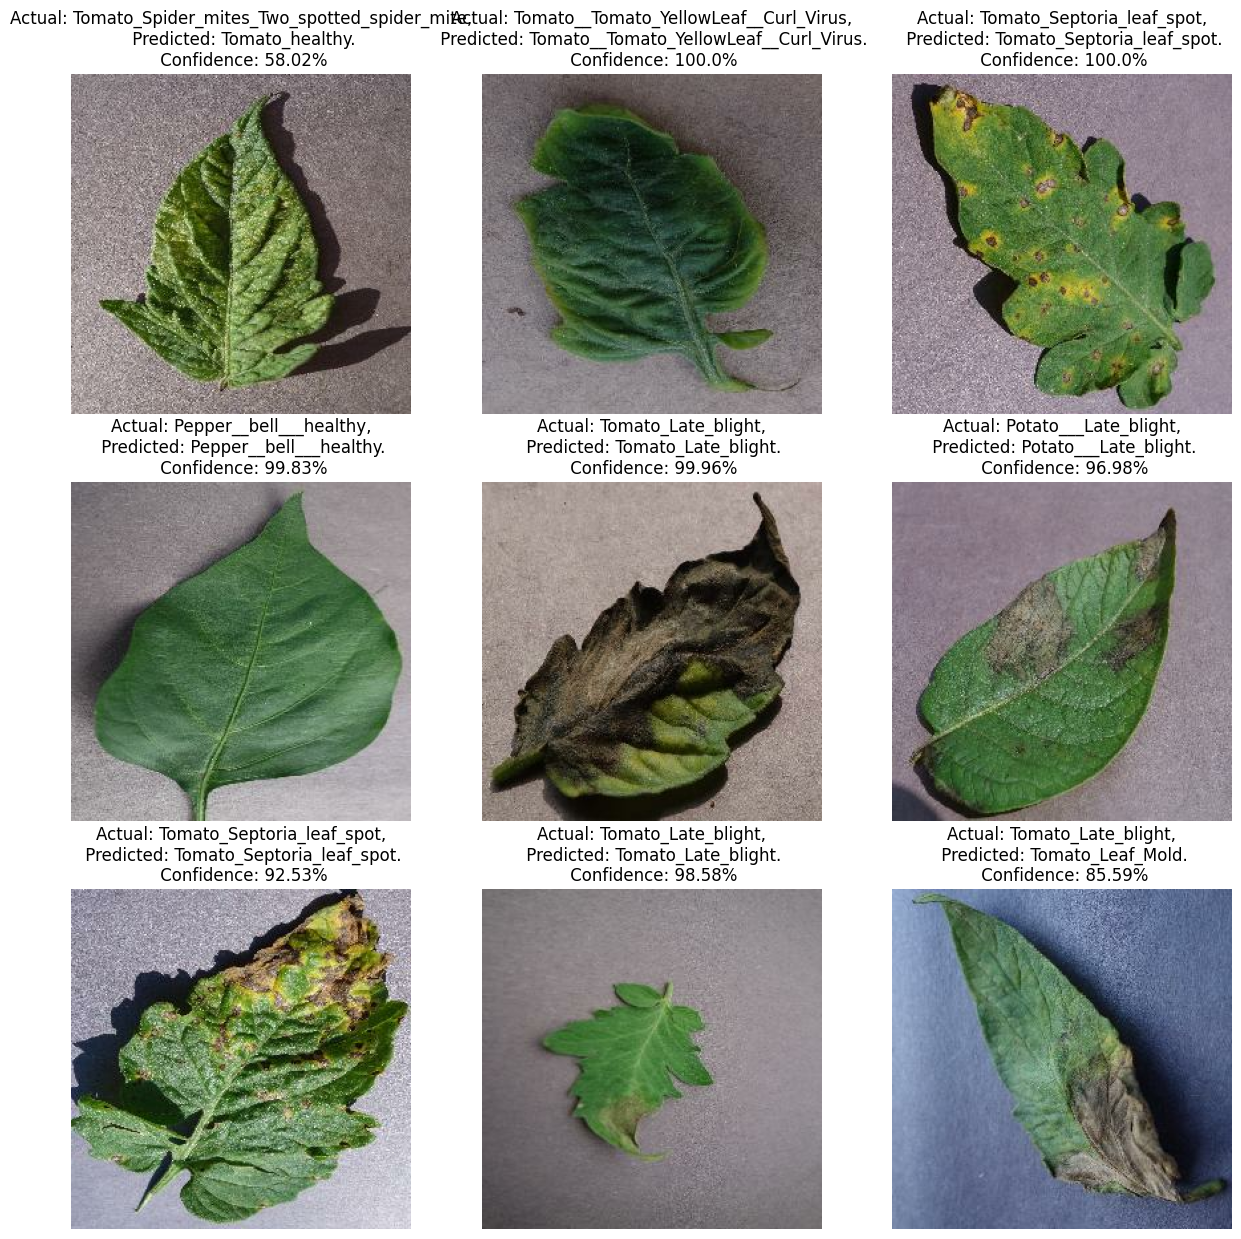

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [35]:
import os
model_dir = "../saved-models/plant-disease-model-with-split-folders"
model_version = max([int(i) for i in os.listdir("../saved-models/plant-disease-model-with-split-folders") + [0]])+1
model_export_path = f"{model_dir}/{model_version}"

tf.saved_model.save(
    model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")

INFO:tensorflow:Assets written to: ../saved-models/plant-disease-model-with-split-folders/1\assets


INFO:tensorflow:Assets written to: ../saved-models/plant-disease-model-with-split-folders/1\assets


SavedModel files: ['assets', 'fingerprint.pb', 'saved_model.pb', 'variables']


In [36]:
model.save("../models/plants-disease-with-split-folders.h5")